# Отчет: задание 1

*Неверо Андрей, лабораторная работа 1, 2 курс, 4 группа*

В задании требовалось написать программу, которая эффективно вычисляет обратную матрицу к матрицам почти треугольного вида.

Решением данной задачи можно считать реализацию методов *CountTluDecomposition_AlmostTriangular*, *SolveSystem_AlmostTriangular* и *CountInverseMatrix_AlmostTriangular* класса Matrix (см. соответствующий заголовочный файл).

Обработка связанных с этим заданием входных данных вынесена в отдельный класс, определенный в заголовочном файле *Task1*.

## Основная идея алгоритма

Тот факт, что матрица является почти треугольной, позволяет сильно сократить количество операций вычитания (и связанных с ними операций деления) при нахождении LU-разложения матрицы и при решении системы вида $AX = B$ с помощью этого разложения.

Действительно, рассмотрим один шаг стандартного алгоритма LU-разложения. Будем считать, что текущая матрица - это матрица $U$ (в конце концов она должна ею стать).

1. Записать текущий столбец, разделенный на его первый элемент, в соответствующий столбец матрицы $L$. Здесь оптимизировать ничего не получится - этот столбец может быть совершенно случайным.
2. Занулить первый столбец матрицы $U$. Для этого нужно прибавить текущую строку, домноженную на коэффициент, ко всем последующим строкам матрицы. Для этого нам нужно $O(n^2)$ времени: ведь прибавить что-либо нужно к каждому элементу подматрицы. Но нетрудно заметить, что в нашем случае есть смысл прибавлять что-либо только к элементам текущего и последующего столбца. Все остальные элементы текущей строки матрицы $U$ являются нулевыми, и, независимо от коэффициента, прибавлять придется ноль. Соответственно, мы можем сильно сократить количество операций и перейти к асимптотике $O(n)$.

В итоге от алгоритма, работающего за $O(n^3)$, мы перешли к алгоритму, работающему за $O(n^2)$. Правда, не все так гладко, как может показаться на первый взгляд.
* Перестановки строк и столбцов матрицы фактически недопустимы. Нетрудно заметить, что любая перестановка сломает структуру матрицы и сделает невозможным дальнейшее применение оптимизированного алгоритма. Возможно, это может повлиять на точность вычислений (чуть ниже мы проверим это на практике).
* Так как перестановки строк и столбцов недопустимы, если мы получим нулевой элемент на диагонали, мы не сможем продолжить применение алгоритма. Следовательно, можно считать, что для подобных матриц этот алгоритм не предназначен.

Ту же идею можно применить при решении системы уравнений $AX = B$. Хотя с матрицей $L$ мы сделать ничего не сможем (она абсолютно обычная), матрица $U$ выглядит достаточно интересно. Нетрудно заметить, что она будет почти диагональной (будет иметь двойную диагональ). Следовательно, при подъеме вверх в процессе решения матричного уравнения $UX = B'$ мы можем сократить количество операций вычитания и в итоге перейти от асимптотики $O(n^2)$ к асимптотике $O(n)$. Правда, общая асимптотика нахождения решения все равно останется на уровне $O(n^2)$ из-за работы с матрицей $L$.

Так как нахождение обратной матрицы сводится к нахождению LU-разложения и решению систем, все описанные выше оптимизации должны положительным образом повлиять на скорость работы соответствующих функций.

## Оптимизация алгоритма нахождения обратной матрицы

Как для обычных матриц, так и для рассматриваемых матриц специального вида возможно применение двух идей для оптимизации времени работы алгоритма нахождения обратной матрицы. Эти оптимизации не влияют на асимптотику и зависят от аппаратного обеспечения компьютера, но на практике в разы или десятки раз ускоряют работу программы.

1. Нахождение отдельных столбцов обратной матрицы не по очереди, а всех сразу (то есть в процессе происходит отнимание целых строк матрицы друг от друга).
2. Распределение задачи нахождения отдельных столбцов матрицы между несколькими ядрами процессора (реализация многопоточности).

Первая идея основана на оптимизациях, которые предоставляются модулями SSE и AVX процессора. При компиляции с оптимизациями итоговый код может использовать векторизованные инструкции, которые позволяют одной инструкцией вычитать сразу целый ряд чисел от другого. Вторая идея основана на том, что вычисление отдельных столбцов обратной матрицы никак не пересекается, и его безопасно можно разбить на несколько ядер процессора.

Плюсы первой идеи:
* Простота реализации (векторизация алгоритма происходит на уровне компилятора, а не программиста).
* Заметный выигрыш в производительности на любых более-менее современных компьютерах.

Минусы первой идеи:
* Зависимость от компилятора. Нельзя конкретно указать, что конкретные инструкции в коде нужно векторизовать, компилятор решает это сам (причем чаще всего - только при явном указании соответствующего флага).
* Относительно низкая масштабируемость. Возможности SSE и AVX ограничены, и проводить вычитания рядов по тысяче элементов эти модули не могут (и вряд ли смогут в перспективе).

Плюсы второй идеи:
* Возможность переиспользования кода: в процессе вычисления обратной матрицы можно использовать обычный алгоритм решения системы уравнений $AX = B$.
* Гарантированное увеличение производительности. Его степень зависит от вашего процессора, но увеличение скорости работы алгоритма будет явным и однозначно заметным. При этом оно не будет зависеть от компилятора.
* Высокая масштабируемость. Уже сейчас в продаже есть процессоры с десятками ядер, что позволяет увеличить скорость работы алгоритма в десятки раз. Найти процессор с большим количеством ядер легче, чем найти процессор с более продвинутыми модулями SSE и AVX.

Минусы второй идеи:
* Сложность реализации. При работе с многопоточностью нужно быть осторожным. К счастью, в C++11 были предоставлены достаточно мощные, но при этом простые в освоении методы распараллеливания алгоритмов.
* На слабых компьютерах выигрыш во времени будет не очень большим (меньше, чем выигрыш, предоставляемый модулями SSE и AVX).

Эти две идеи можно и совместить, но такая реализация будет более сложной, и уже выходит за рамки обычной лабораторной работы. Мною было принято решение использовать вторую идею ускорения работы алгоритма.

## Пункт 1

Найденная обратная матрица выглядит следующим образом (точность до 5 знаков после точки):

$$ X = \begin{bmatrix}
        4.6667 & -2.33333 & -1.66667 & 3.33333 \\
        15 & -7 & -5 & 10 \\
        -6 & 3 & 2 & -4 \\
        -22 & 10 & 7 & -15
\end{bmatrix} $$

Абсолютно точное решение получить не удалось в связи с делением на тройку, но и полученный результат очень неплох (погрешность минимальна). Точность до пяти знаков после запятой обеспечивает как тип *long double*, так и обычный *float*.

## Пункт 2

Заданная матрица является вырожденной: у нее линейно зависимы как минимум первые две строк. Следовательно, нахождение обратной матрицы не представляется возможным.

## Пункт 3

Проанализируем время работы обычного алгоритма (для случайных матриц) и оптимизированного (для почти треугольных) на разных типах вещественных чисел. Для этого воспользуемся функцией *RandomInput* в классе *Task1*.

Данная функция генерирует случайную почти треугольную матрицу определенного размера (значения в матрице - возмущенные от $1$ до $5000$), после чего подсчитывает время работы обычного и оптимизированного алгоритма по нахождению обратной матрицы для трех типов - *float*, *double* и *long double*.

Данная функция запускалась для матриц размером до $500$. Для каждого размера проводилось 5 тестов, подсчитывались средние значения затраченного времени и погрешности. Полученные результаты для типов *float*, *double* и *long double* можно увидеть ниже. График красного цвета - график работы обычного алгоритма, синего цвета - оптимизированного. Величины на оси слева - микросекунды.

In [1]:
from data import task1
import matplotlib
%matplotlib inline

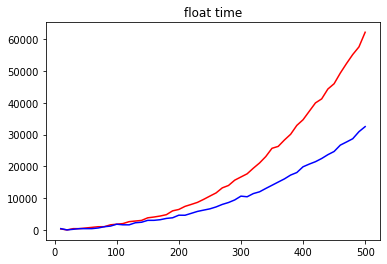

In [2]:
bins = [i for i in range(10, 501, 10)]
matplotlib.pyplot.title("float time")
matplotlib.pyplot.plot(bins, task1.float_common_time, 'r', bins, task1.float_optimized_time, 'b')
matplotlib.pyplot.show()

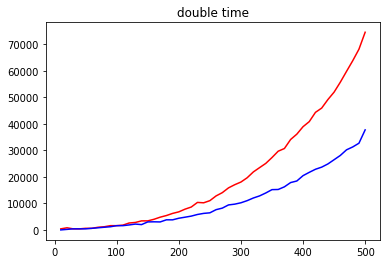

In [3]:
matplotlib.pyplot.title("double time")
matplotlib.pyplot.plot(bins, task1.double_common_time, 'r', bins, task1.double_optimized_time, 'b')
matplotlib.pyplot.show()

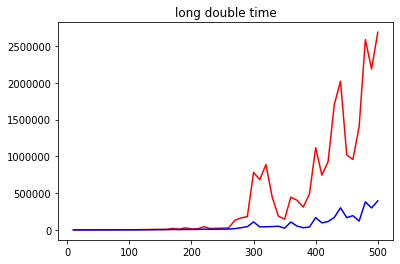

In [4]:
matplotlib.pyplot.title("long double time")
matplotlib.pyplot.plot(bins, task1.long_double_common_time, 'r', bins, task1.long_double_optimized_time, 'b')
matplotlib.pyplot.show()

Как видно, уже начиная с матриц размером  около 100 оптимизированный алгоритм справляется с вычислениями примерно в два раза быстрее. Это и логично: мы вычисляем примерно в два раза меньше значений.

Сравним для интереса время работы обычного и оптимизированного алгоритмов на разных типах вещественных чисел. Желтым цветом обозначен график *long double*, черным - *double*, зеленым - *float*.

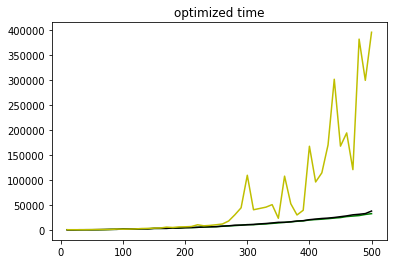

In [5]:
matplotlib.pyplot.title("optimized time")
matplotlib.pyplot.plot(bins, task1.float_optimized_time, 'g', bins, task1.double_optimized_time, 'k', bins, task1.long_double_optimized_time, 'y')
matplotlib.pyplot.show()

Мы получили достаточно ожидаемый результат: работа с типом *long double* действительно медленнее, чем с типами *float* и *double*. Это можно объяснить тем, что математический сопроцессор (FPU), который обрабатывает 80-битные вещественные числа, уступает в скорости модулям SSE, занимающимися обработкой 32-разрядных и 64-разрядных вещественных чисел.

Ответим на вопрос, матрицу какого размера конкретный компьютер сможет обработать за одну минуту. Как показала практика, используя оптимизированный алгоритм, на моем компьютере за минуту можно найти обратную матрицу к:

* Матрице размером $n \approx 2750$ типа *float*
* Матрице размером $n \approx 2550$ типа *double*
* Матрице размером $n \approx 2450$ типа *long double*

На компьютере с большим количеством ядер (8 против 2) и потоков (16 против 4) за минуту оптимизированный алгоритм смог обработать матрицу типа *double* размером $n \approx 4750$ (именно на этом компьютере проводились тесты, результаты которых в виде графиков приведены выше).

Сравним время работы оптимизированного алгоритма без многопоточности и с ней. Для каждой из матриц типа *double* размером $n = 25k$ ($n \leq 2000$) было запущено по пять тестов, использовался компьютер с восьмиядерным процессором. В случае необходимости результаты можно воспроизвести на другом компьютере путем запуска функции *SingleVsMultiThread*.

Красный график отвечает за однопоточный алгоритм, синий - за многопоточный.

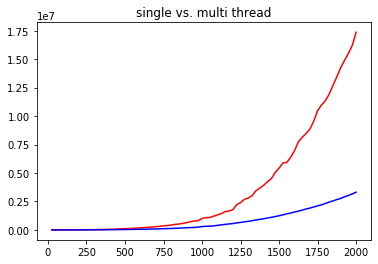

In [7]:
bins = [i for i in range(25, 2001, 25)]
matplotlib.pyplot.title("single vs. multi thread")
matplotlib.pyplot.plot(bins, task1.double_single_thread_time, 'r', bins, task1.double_multi_thread_time, 'b')
matplotlib.pyplot.show()

Если в начале, для матриц размером до примерно $n \approx 400$, обычный алгоритм работает так же или даже быстрее, чем многопоточный, уже начиная с $n = 600$ разница между ними становится все более заметна. Это можно легко объяснить тем фактом, что для небольших $n$ накладные расходы на создание и контроль потоков превышают выигрыш от их использования. Но этот эффект исчезает при достаточно больших $n$.

При увеличении числа доступных ядер разница между двумя алгоритмами становится все больше и больше.

Напоследок еще раз отметим, что можно улучшить в текущем алгоритме:
* Оптимизация работы с памятью. На данный момент каждый столбец обратной матрицы считается отдельно и копируется в основную матрицу. Можно попробовать избежать этого копирования.
* Оптимизация работы с SSE и AVX. Можно попробовать совместить многопоточность и проведение операций сразу над всей матрицей (а не только над конкретным столбцом). Потенциал SSE и AVX может позволить уменьшить время работы программы даже в $\approx 8$ раз (правда, это улучшение будет константным, то есть для матриц большего размера мы получим увеличение скорости в те же $8$ раз).